In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.7 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import lightgbm as lgb

# Scikit-Learn estimators
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Model Evaluations
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score # Separate lines to keep everyting "Pythonic"
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# To handle warnings
import warnings

In [4]:
from google.colab import files
uploaded = files.upload()

Saving starbucks_reviews_data.csv to starbucks_reviews_data.csv


In [5]:
dataset = pd.read_csv('starbucks_reviews_data.csv')

In [6]:
dataset

name            location                     Date  Rating  \
0        Helen   Wichita Falls, TX  Reviewed Sept. 13, 2023     5.0   
1     Courtney          Apopka, FL   Reviewed July 16, 2023     5.0   
2     Daynelle   Cranberry Twp, PA    Reviewed July 5, 2023     5.0   
3       Taylor         Seattle, WA    Reviewed May 26, 2023     5.0   
4      Tenessa         Gresham, OR   Reviewed Jan. 22, 2023     5.0   
..         ...                 ...                      ...     ...   
845      Becky    Agoura Hills, CA   Reviewed July 13, 2006     NaN   
846        Bob        Goodrich, MI    Reviewed Jan. 3, 2005     NaN   
847       Erik  Valley Village, CA    Reviewed Nov. 5, 2004     NaN   
848     Andrew       Fallbrook, CA   Reviewed Oct. 20, 2004     NaN   
849  Christian          Ramsey, NJ   Reviewed July 19, 2000     NaN   

                                                Review  \
0    Amber and LaDonna at the Starbucks on Southwes...   
1    ** at the Starbucks by the fire station on 436...   
2    I just wanted to go out of my way to recognize...   
3    Me and my friend were at Starbucks and my card...   
4    I’m on this kick of drinking 5 cups of warm wa...   
..                                                 ...   
845  I ordered two venti frappacino's without whipp...   
846                                     No Review Text   
847  DEMANDED TIPS FROM ME, THEN MADE ME WAIT UNTIL...   
848                                     No Review Text   
849                                     No Review Text   

                                           Image_Links  
0                                        ['No Images']  
1                                        ['No Images']  
2    ['https://media.consumeraffairs.com/files/cach...  
3                                        ['No Images']  
4    ['https://media.consumeraffairs.com/files/cach...  
..                                                 ...  
845                                      ['No Images']  
846                                      ['No Images']  
847                                      ['No Images']  
848                                      ['No Images']  
849                                      ['No Images']  

[850 rows x 6 columns]

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


In [8]:
dataset.isnull().sum()

name             0
location         0
Date             0
Rating         145
Review           0
Image_Links      0
dtype: int64

In [9]:
dataset.describe()

Rating
count  705.000000
mean     1.870922
std      1.397672
min      1.000000
25%      1.000000
50%      1.000000
75%      2.000000
max      5.000000

In [20]:
mean_rating = dataset['Rating'].mean()
dataset['Rating'].fillna(mean_rating, inplace=True)

In [21]:
dataset.isnull().sum()

name           0
location       0
Date           0
Rating         0
Review         0
Image_Links    0
dtype: int64

In [22]:
dataset.columns

Index(['name', 'location', 'Date', 'Rating', 'Review', 'Image_Links'], dtype='object')

In [23]:
dataset["Rating"]=dataset["Rating"].astype(int)

In [24]:
dataset["Rating"].value_counts()

Rating
1    596
2     99
5     83
4     39
3     33
Name: count, dtype: int64

<ipython-input-25-1f514a3d5d40>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Rating",data=dataset,palette="cool")


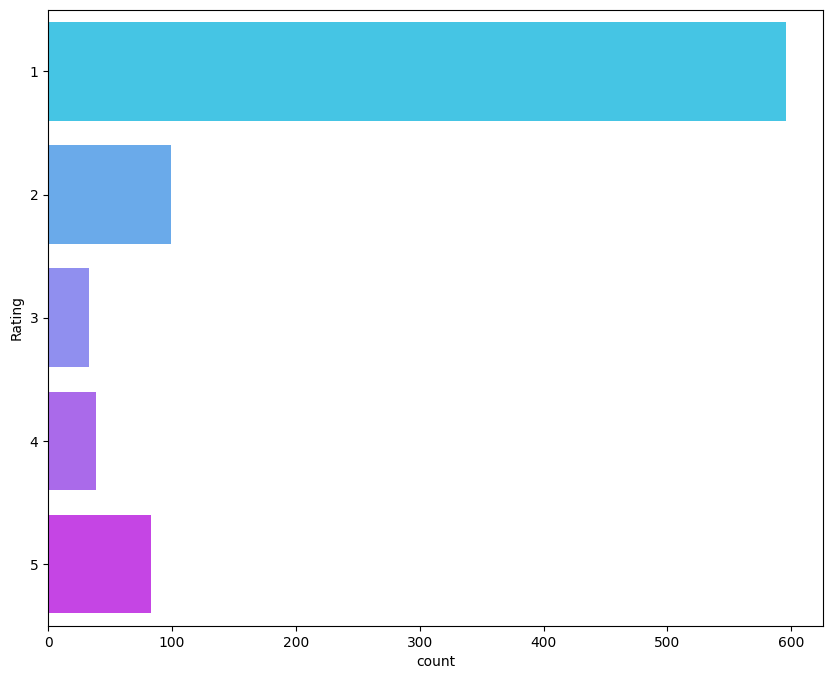

In [25]:
plt.figure(figsize=(10,8))
sns.countplot(y="Rating",data=dataset,palette="cool")
plt.show()

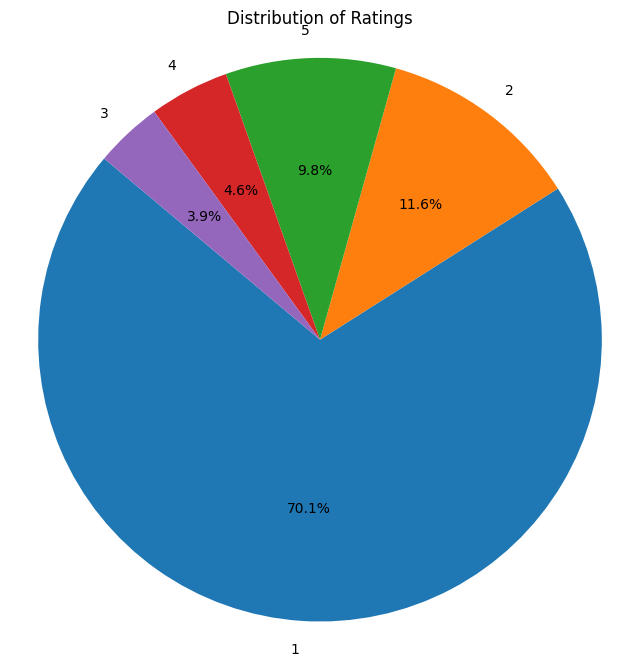

In [26]:
rating_counts = dataset["Rating"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Ratings')
plt.axis('equal')
plt.show()

In [27]:
dataset["location"].value_counts()

location
New York, NY       14
Los Angeles, CA    12
Seattle, WA        11
Chicago, IL         9
Las Vegas, NV       8
                   ..
Chantilly, VA       1
St. John's, NL      1
Lorton, VA          1
Anaheim, CA         1
Ramsey, NJ          1
Name: count, Length: 633, dtype: int64

<ipython-input-28-842a9f86589f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="location",data=dataset[:50],palette="cool")


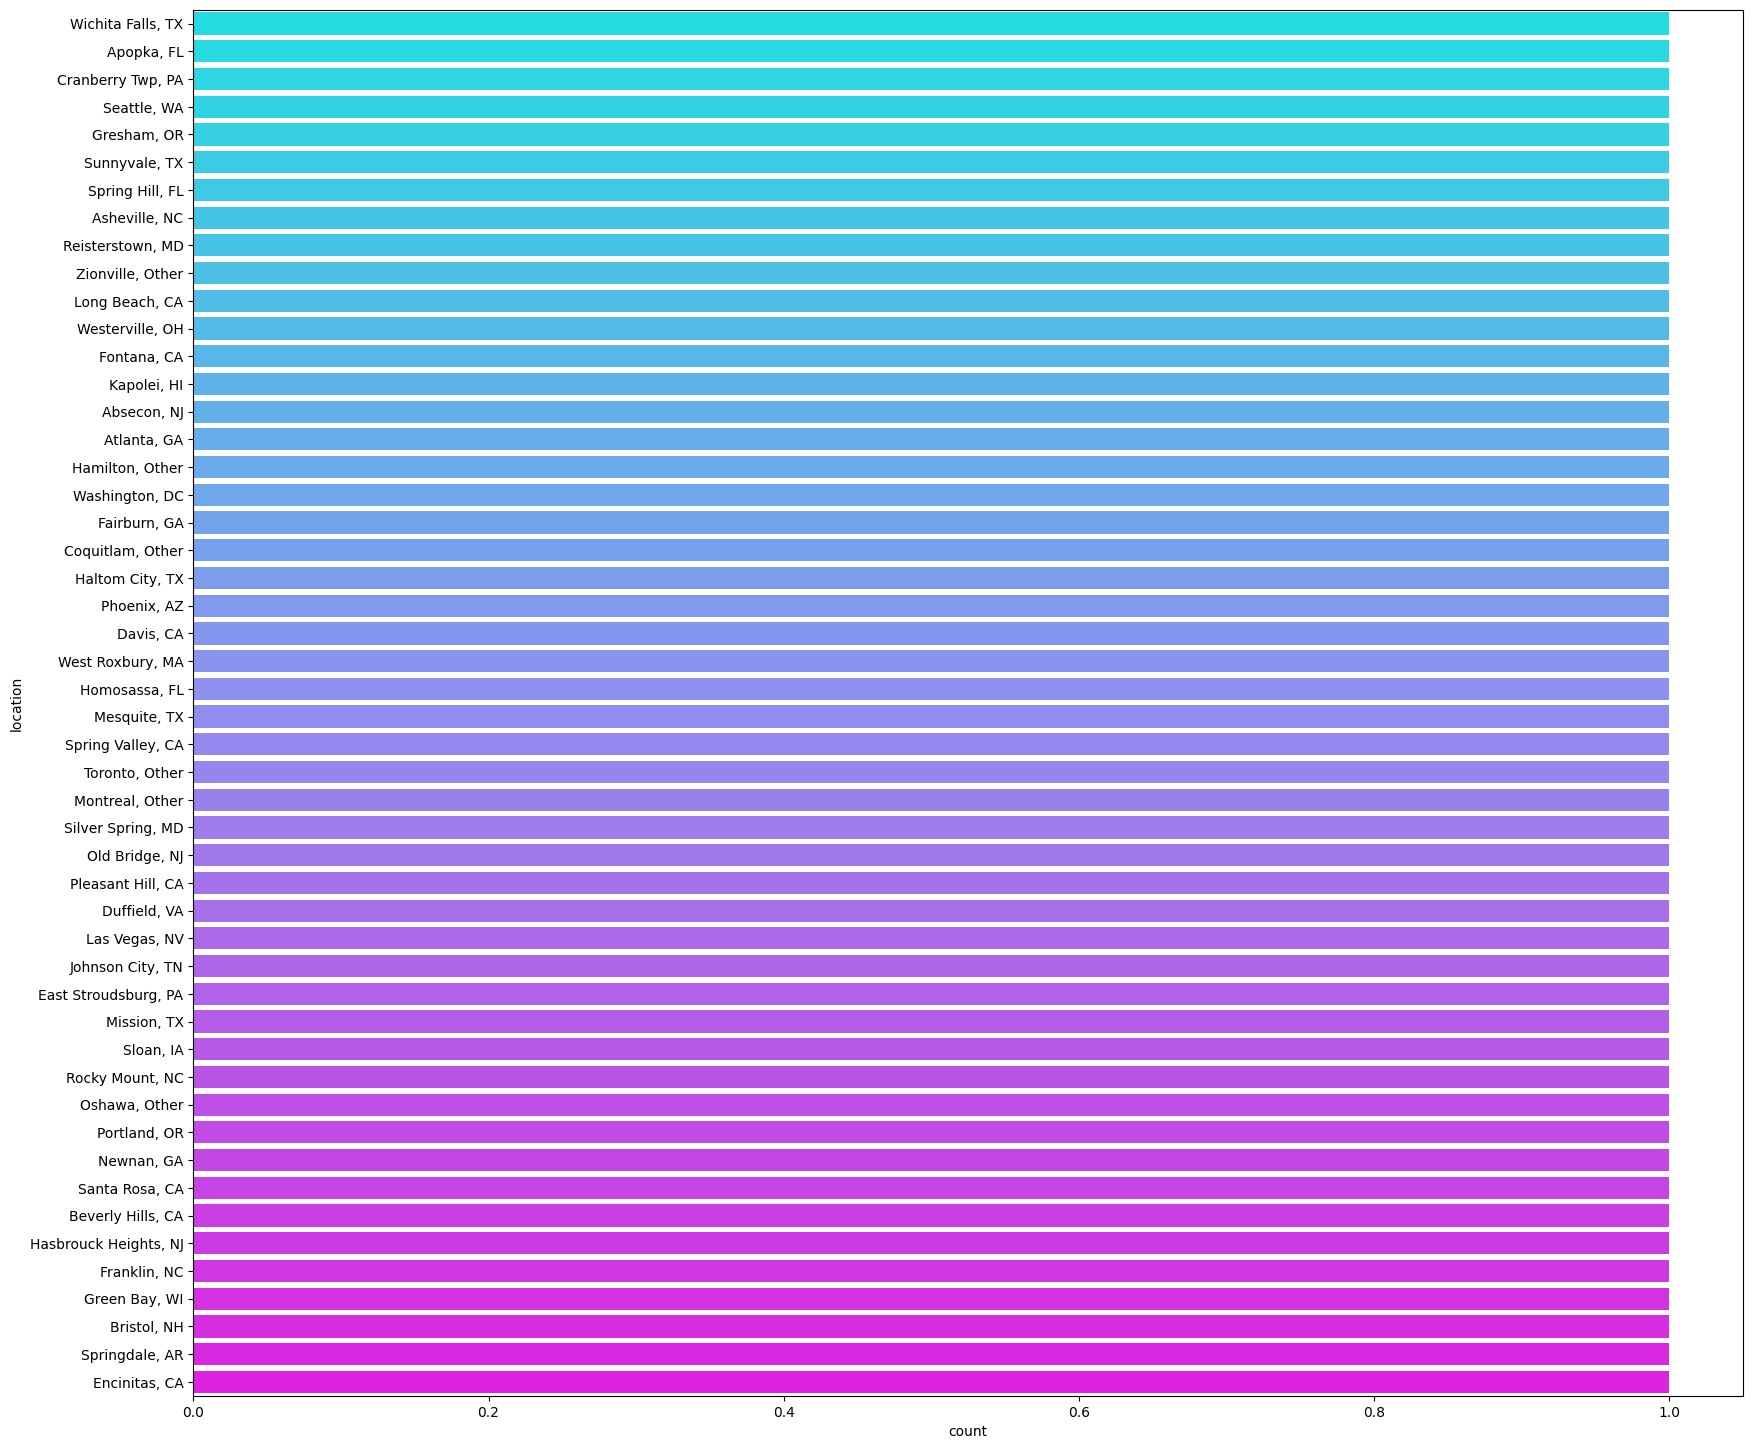

In [28]:
plt.figure(figsize=(20,18))
sns.countplot(y="location",data=dataset[:50],palette="cool")
plt.show()

Data pre-processing and visualization of some of the selected features..

In [29]:
dataset.drop(columns=["name","location","Date","Image_Links"],axis=1,inplace=True)

In [30]:
dataset.head()

Rating                                             Review
0       5  Amber and LaDonna at the Starbucks on Southwes...
1       5  ** at the Starbucks by the fire station on 436...
2       5  I just wanted to go out of my way to recognize...
3       5  Me and my friend were at Starbucks and my card...
4       5  I’m on this kick of drinking 5 cups of warm wa...

In [31]:
def map_sentiment(score):
    if score in [1, 2]:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    elif score in [4, 5]:
        return 'Positive'
    else:
        return 'Unknown'
dataset['Rating'] = dataset.Rating.apply(map_sentiment)

In [32]:
dataset.rename(columns={"Rating":"label"},inplace=True)
dataset.rename(columns={"Review":"text"},inplace=True)

In [33]:
dataset["label"].value_counts()

label
Negative    695
Positive    122
Neutral      33
Name: count, dtype: int64

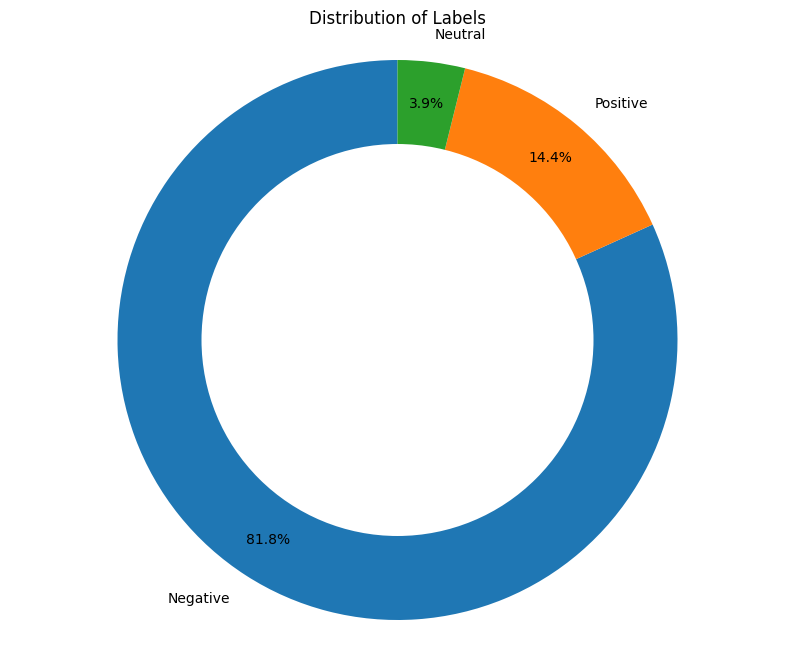

In [34]:
label_counts = dataset["label"].value_counts()

plt.figure(figsize=(10,8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
plt.title('Distribution of Labels')
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))
plt.axis('equal')
plt.show()

<ipython-input-35-fb4821a629c4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label",data=dataset,palette="hot")


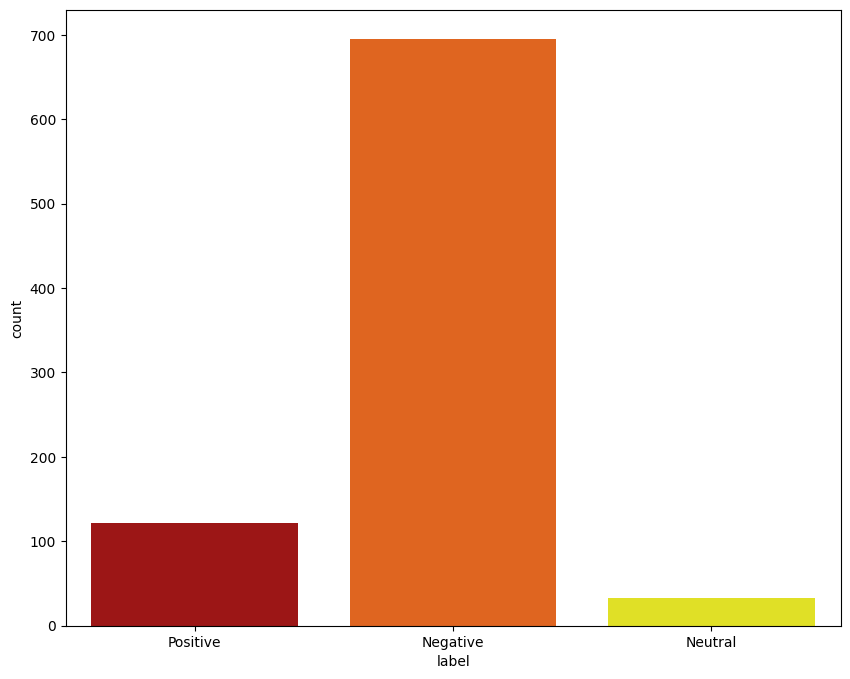

In [35]:
plt.figure(figsize=(10,8))
sns.countplot(x="label",data=dataset,palette="hot")
plt.show()

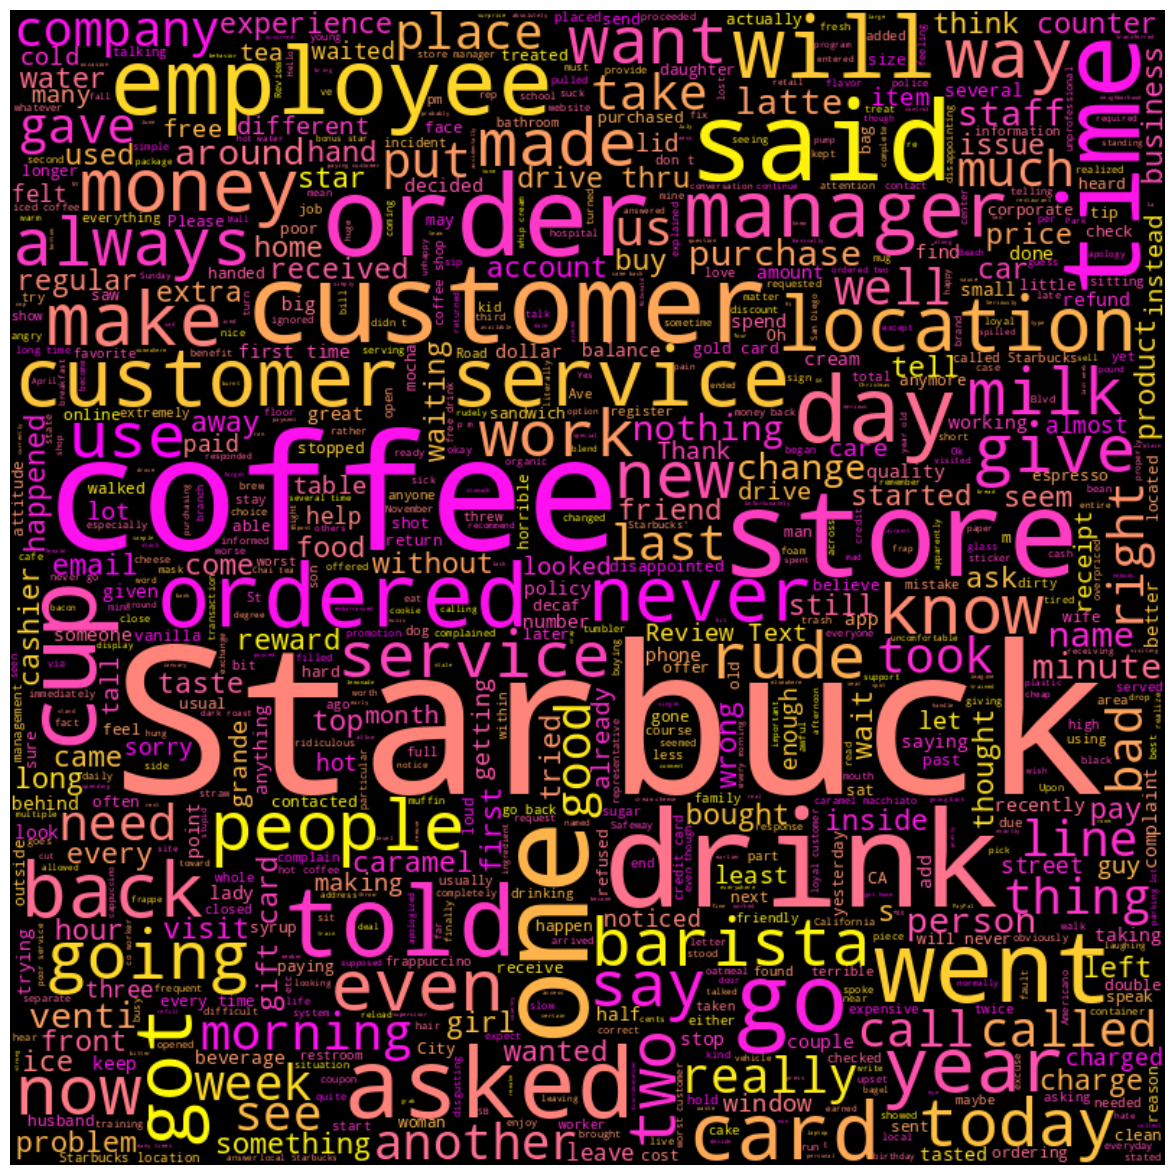

In [42]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(15,15))
negative_wordcloud=dataset[dataset["label"]=="Negative"]
negative_text=" ".join(negative_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="spring",).generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

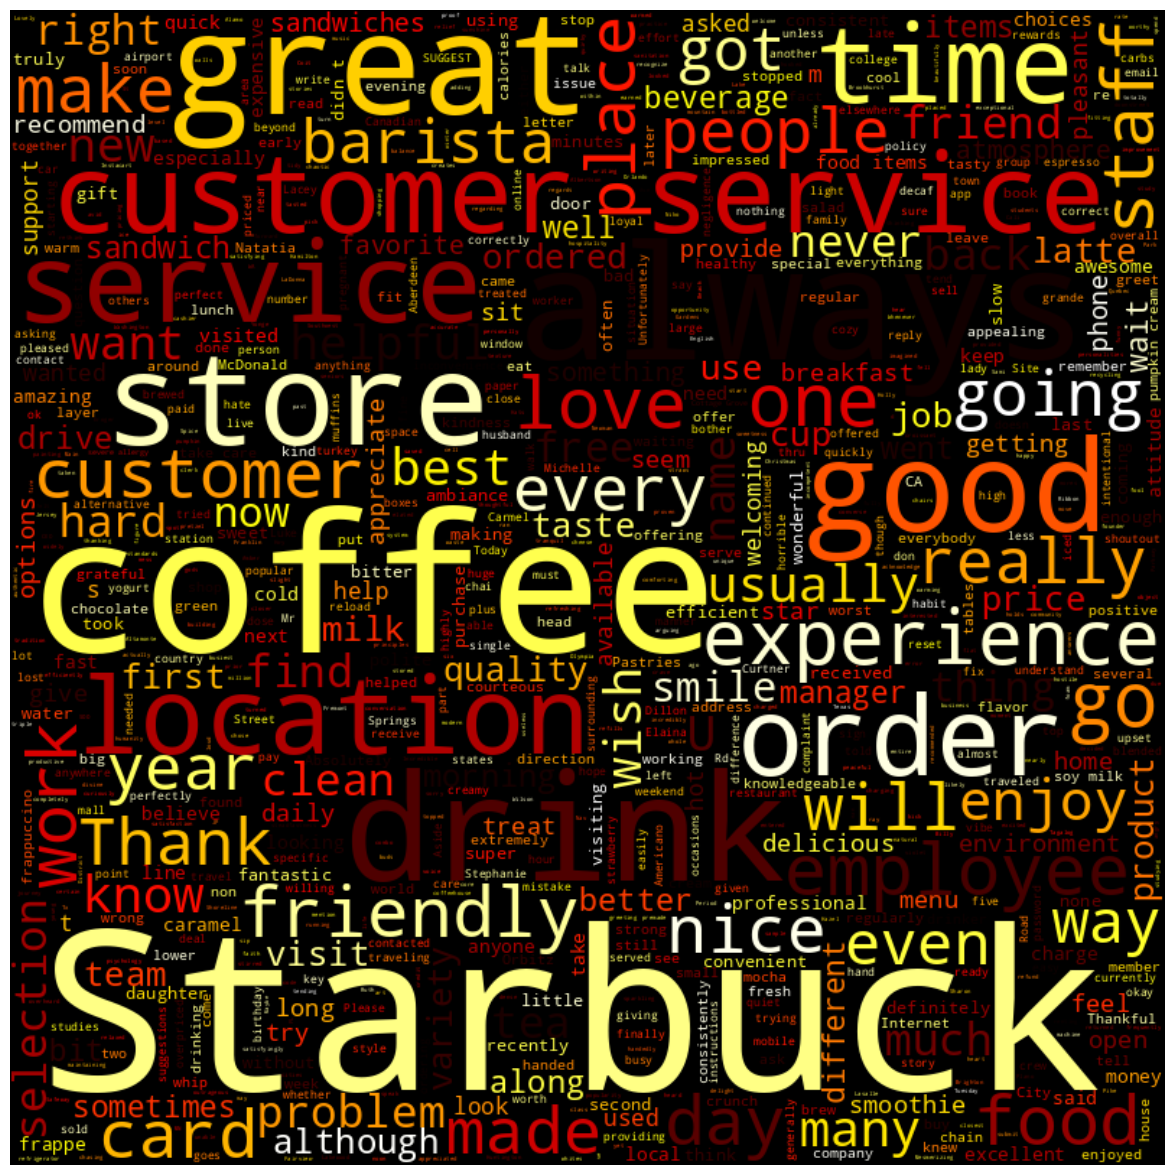

In [43]:
plt.figure(figsize=(15,15))
positive_wordcloud=dataset[dataset["label"]=="Positive"]
positive_text=" ".join(positive_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="hot",).generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

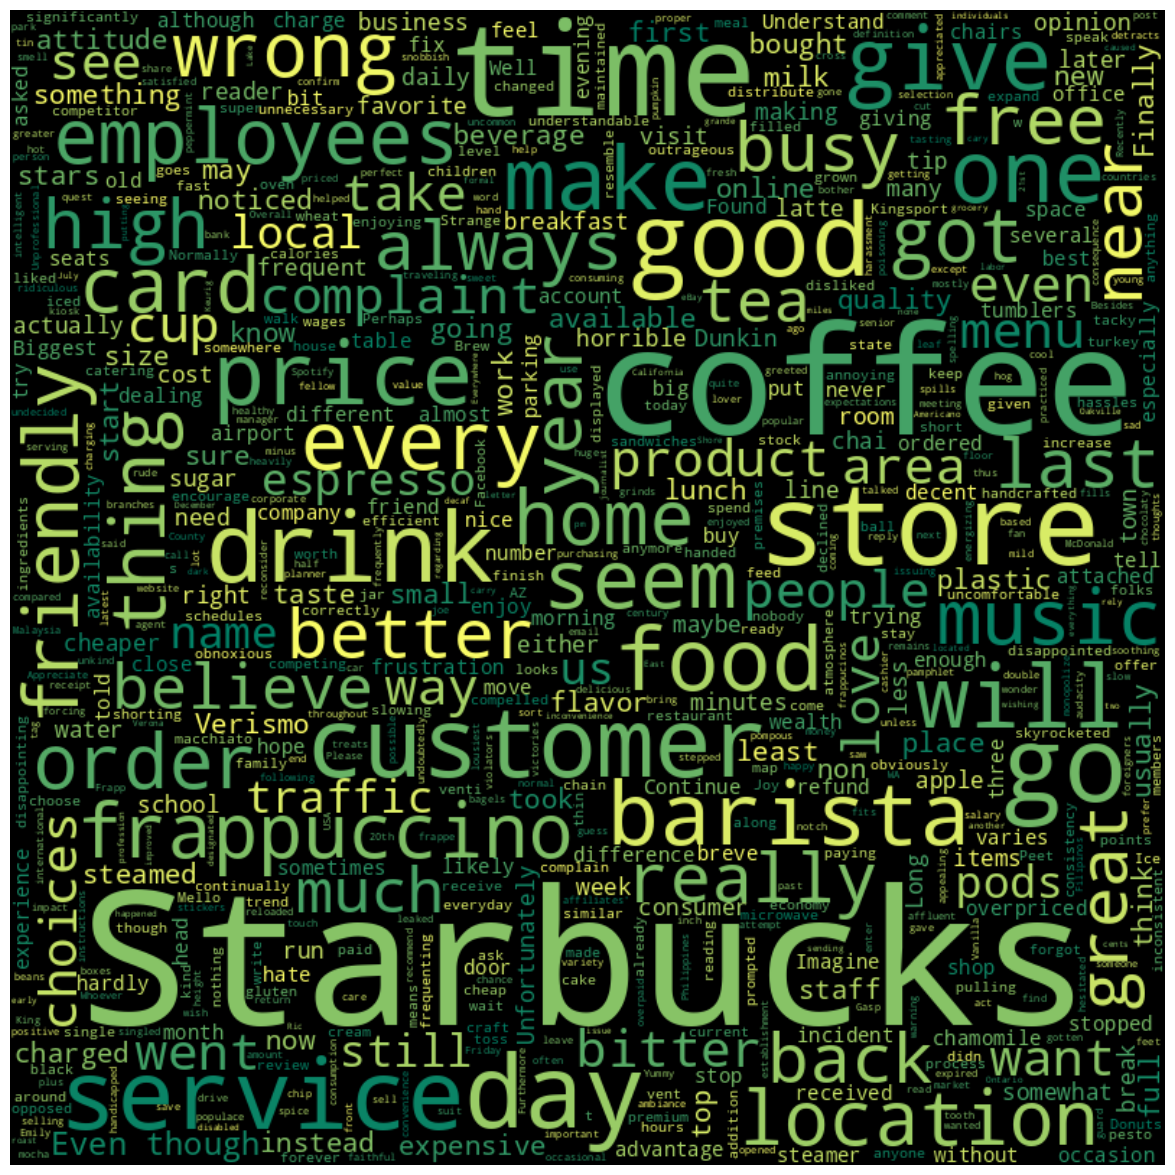

In [44]:
plt.figure(figsize=(15,15))
neutral_wordcloud=dataset[dataset["label"]=="Neutral"]
neutral_text=" ".join(neutral_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="summer",).generate(neutral_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<ipython-input-46-d93112e5c262>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=dataset_common_words,palette="gist_stern")


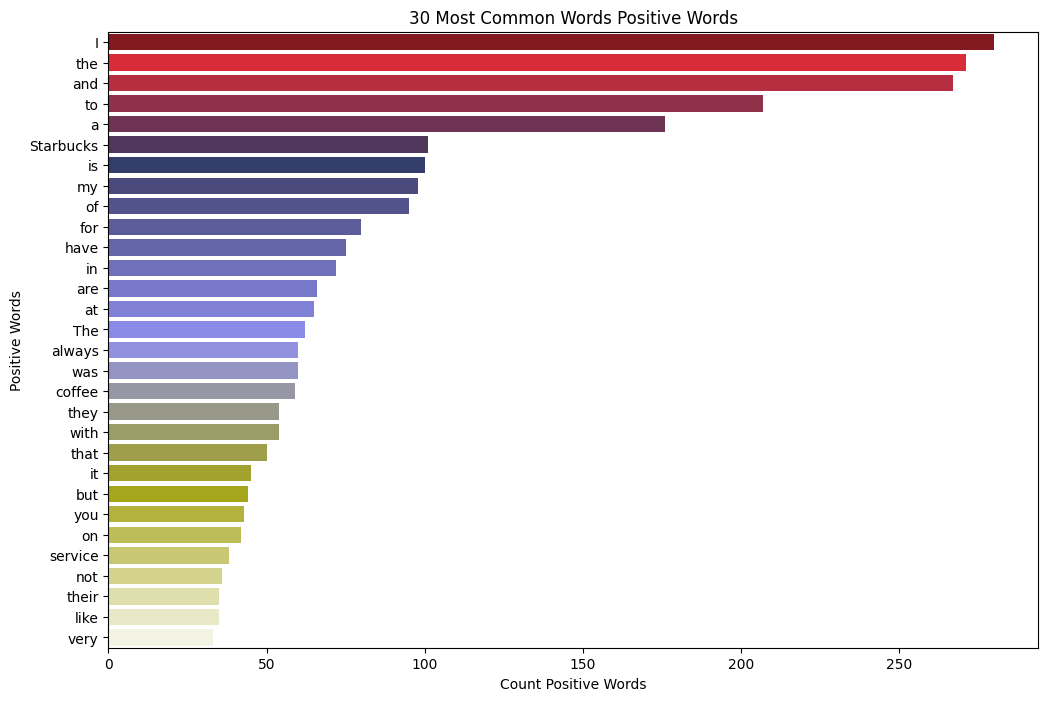

In [46]:
from collections import Counter

positive_text = dataset[dataset["label"] == "Positive"]
data_set = positive_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]
counter = Counter(all_words)
common_words = counter.most_common(30)
dataset_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=dataset_common_words,palette="gist_stern")
plt.title('30 Most Common Words Positive Words')
plt.xlabel('Count Positive Words')
plt.ylabel('Positive Words')
plt.show()

<ipython-input-47-25bff0a259d4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=dataset_common_words,palette="gist_ncar")


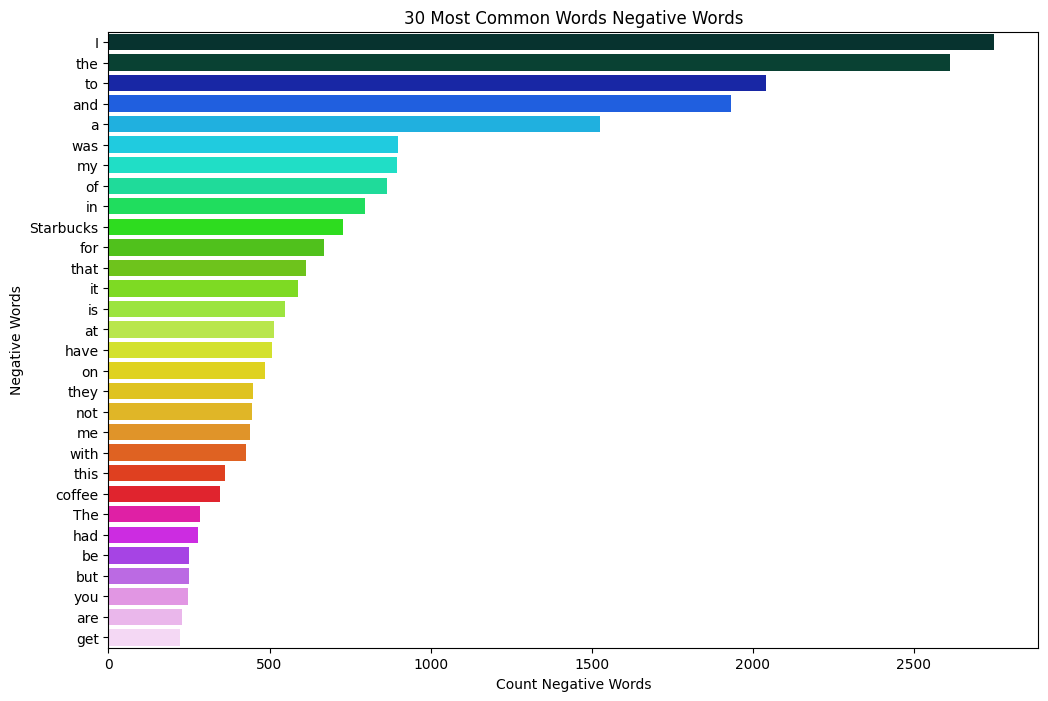

In [47]:
negative_text = dataset[dataset["label"] == "Negative"]
data_set = negative_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]
counter = Counter(all_words)
common_words = counter.most_common(30)
dataset_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=dataset_common_words,palette="gist_ncar")
plt.title('30 Most Common Words Negative Words')
plt.xlabel('Count Negative Words')
plt.ylabel('Negative Words')
plt.show()

<ipython-input-48-b5a16b72ba80>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=dataset_common_words,palette="cubehelix")


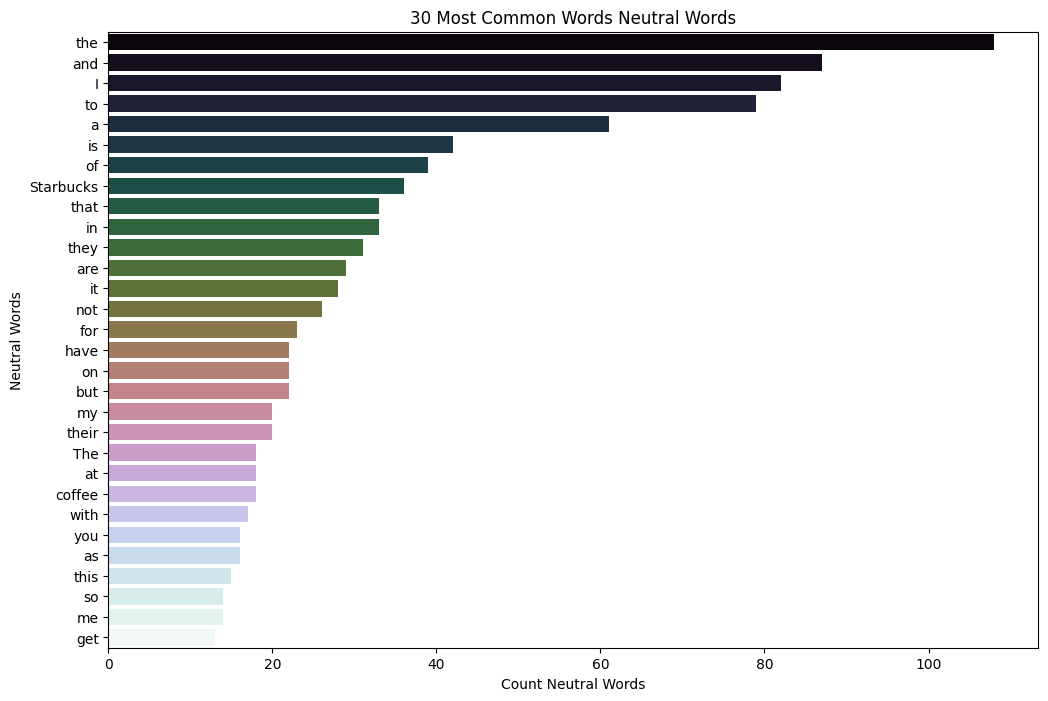

In [48]:
neutral_text = dataset[dataset["label"] == "Neutral"]
data_set = neutral_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]
counter = Counter(all_words)
common_words = counter.most_common(30)
dataset_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=dataset_common_words,palette="cubehelix")
plt.title('30 Most Common Words Neutral Words')
plt.xlabel('Count Neutral Words')
plt.ylabel('Neutral Words')
plt.show()

In [49]:
dataset["text_length"]=dataset["text"].apply(len)

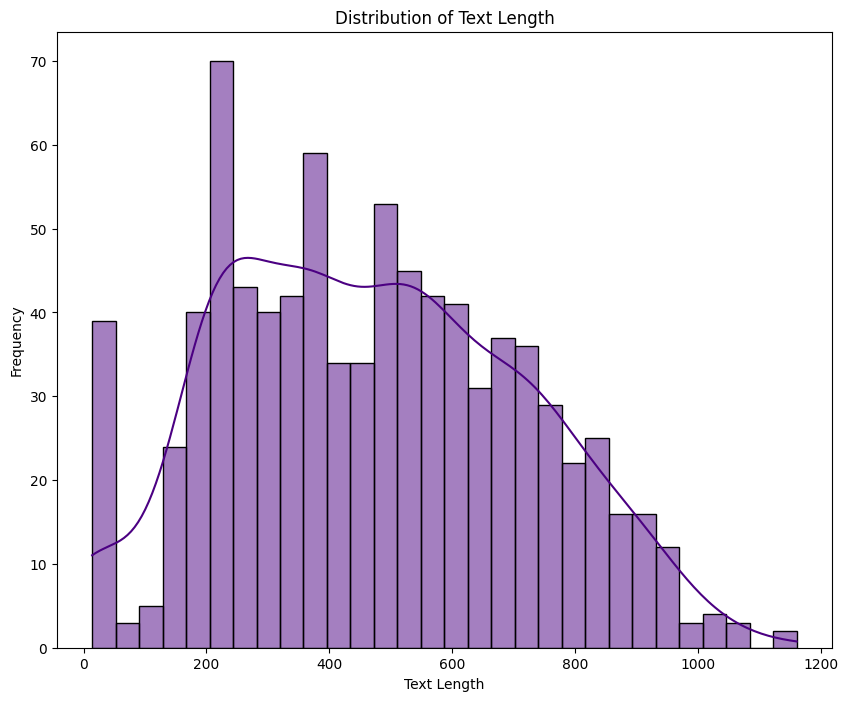

In [50]:
plt.figure(figsize=(10,8))
sns.histplot(dataset["text_length"], bins=30, kde=True,color="indigo")
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [51]:
avg_len=dataset["text"].apply(len)
avg_len=avg_len.mean()
print(f"Average Text Length is : {avg_len:.2f}")

Average Text Length is : 471.06


In [52]:
dataset.drop(columns=["text_length"],axis=1,inplace=True)

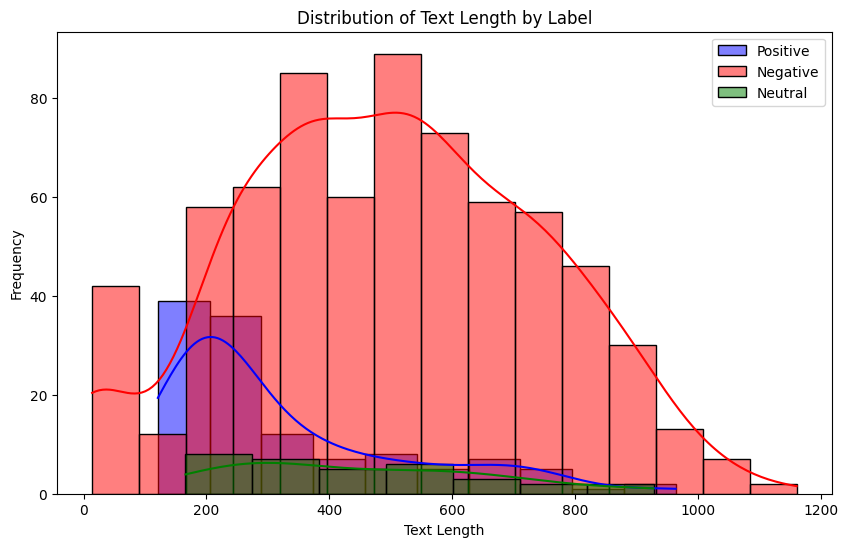

In [53]:
dataset_positive=dataset[dataset["label"]=="Positive"]["text"].str.len()
dataset_negative=dataset[dataset["label"]=="Negative"]["text"].str.len()
dataset_neutral=dataset[dataset["label"]=="Neutral"]["text"].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(dataset_positive, color='blue', alpha=0.5, label='Positive', kde=True)
sns.histplot(dataset_negative, color='red', alpha=0.5, label='Negative', kde=True)
sns.histplot(dataset_neutral, color='green', alpha=0.5, label='Neutral', kde=True)

plt.title('Distribution of Text Length by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [55]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
max_len=400
sample_text=dataset["text"].iloc[0]
tokenize_data= tokenizer(sample_text, return_tensors='pt', padding=True, truncation=True, max_length=max_len)
print("=======================================================================================================")
print("\n")
print(f"Orginal Text : {sample_text}")
print("\n")
print("=======================================================================================================")
print("=======================================================================================================")
print("=======================================================================================================")
print("\n")
print(f"Encoded Text : {tokenize_data}")



Orginal Text : Amber and LaDonna at the Starbucks on Southwest Parkway are always so warm and welcoming. There is always a smile in their voice when they greet you at the drive-thru. And their customer service is always spot-on, they always get my order right and with a smile. I would actually give them more than 5 stars if they were available.




Encoded Text : {'input_ids': tensor([[    0,   250, 34707,     8,  1587,  6766,  2133,    23,     5, 10173,
            15,  7577, 15787,    32,   460,    98,  3279,     8, 10423,     4,
           345,    16,   460,    10,  6675,    11,    49,  2236,    77,    51,
         17395,    47,    23,     5,  1305,    12,   212,  2070,     4,   178,
            49,  2111,   544,    16,   460,  1514,    12,   261,     6,    51,
           460,   120,   127,   645,   235,     8,    19,    10,  6675,     4,
            38,    74,   888,   492,   106,    55,    87,   195,  2690,   114,
            51,    58,   577,     4,     2]]), 'attention_mask': 

In [56]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=42)
dataset_val, dataset_test = train_test_split(dataset_test, test_size=0.5, random_state=42)

In [57]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
class_distribution=Counter(dataset_train["label"])
print(f"Class Distribution Before Random Oversampling : {class_distribution}")

Class Distribution Before Random Oversampling : Counter({'Negative': 566, 'Positive': 86, 'Neutral': 28})


In [58]:
dataset_train.head()

label                                               text
332   Neutral  Starbucks their daily coffee is good but not g...
383  Negative  Recently, I noticed that the card balance went...
281  Negative  Dear Starbucks Team, received poor service in ...
2    Positive  I just wanted to go out of my way to recognize...
231  Negative  DO NOT drink at STARBUCKS St. Leonards, Ringwo...

In [59]:
X=dataset_train.drop(columns="label",axis=1)
Y=dataset_train["label"]

In [60]:
print("Shapes of X and Y before oversampling:")
print("X shape:", X.shape)
print("Y shape:", Y.shape)

Shapes of X and Y before oversampling:
X shape: (680, 1)
Y shape: (680,)


In [61]:
os=RandomOverSampler(random_state=42)
X_new,Y_new = os.fit_resample(X,Y)
dataset_train_resample = pd.concat([pd.DataFrame(X_new, columns=X.columns), pd.Series(Y_new, name="label")], axis=1)
dataset_train_resample.head()

text     label
0  Starbucks their daily coffee is good but not g...   Neutral
1  Recently, I noticed that the card balance went...  Negative
2  Dear Starbucks Team, received poor service in ...  Negative
3  I just wanted to go out of my way to recognize...  Positive
4  DO NOT drink at STARBUCKS St. Leonards, Ringwo...  Negative

In [62]:
dataset_train_resample.shape

(1698, 2)

In [63]:
class_count_after=Counter(dataset_train_resample["label"])
print(f"After Class Distribution Random OverSampling : {class_count_after}")

After Class Distribution Random OverSampling : Counter({'Neutral': 566, 'Negative': 566, 'Positive': 566})


In [64]:
num_labels = len(set(dataset['label'].tolist()))
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
num_labels

3

In [67]:
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True, max_length=512)
    return tokens

dataset_train_resample["tokenize_text"]=dataset_train_resample["text"].apply(tokenize_text)
dataset_val["tokenize_text"]=dataset_val["text"].apply(tokenize_text)
dataset_test["tokenize_text"]=dataset_test["text"].apply(tokenize_text)

In [68]:
dataset_train_resample.head()

text     label  \
0  Starbucks their daily coffee is good but not g...   Neutral   
1  Recently, I noticed that the card balance went...  Negative   
2  Dear Starbucks Team, received poor service in ...  Negative   
3  I just wanted to go out of my way to recognize...  Positive   
4  DO NOT drink at STARBUCKS St. Leonards, Ringwo...  Negative   

                                       tokenize_text  
0  [0, 4239, 40132, 49, 1230, 3895, 16, 205, 53, ...  
1  [0, 38386, 6, 38, 5324, 14, 5, 1886, 2394, 439...  
2  [0, 23314, 10173, 2711, 6, 829, 2129, 544, 11,...  
3  [0, 100, 95, 770, 7, 213, 66, 9, 127, 169, 7, ...  
4  [0, 19174, 8127, 4076, 23, 22305, 387, 23806, ...

In [69]:
dataset_val.head()

label                                               text  \
96   Positive  Incredible experience every time. Thankful for...   
30   Negative  My account got blocked, I cannot log in and I ...   
33   Negative  On 01/23/2023 I purchased Starbucks beverage l...   
49   Negative  I've recently realized how difficult it is to ...   
433  Negative  I'm sure you've heard a lot of feedback on the...   

                                         tokenize_text  
96   [0, 34366, 29921, 676, 358, 86, 4, 3837, 2650,...  
30   [0, 2387, 1316, 300, 4953, 6, 38, 1395, 7425, ...  
33   [0, 4148, 9465, 73, 1922, 73, 844, 1922, 38, 3...  
49   [0, 100, 348, 682, 5426, 141, 1202, 24, 16, 7,...  
433  [0, 100, 437, 686, 47, 348, 1317, 10, 319, 9, ...

In [70]:
dataset_test.head()

label                                               text  \
174  Negative  This was a drink I was really looking forward ...   
731  Negative  The employee was drunk and incoherent, obvious...   
286  Negative  Starbucks is getting more and more pricey for ...   
696  Negative  I ordered a tall split drip cup coffee 1/2 bol...   
29   Negative  I bought a Caramel macchiato last night on 03/...   

                                         tokenize_text  
174  [0, 713, 21, 10, 4076, 38, 21, 269, 546, 556, ...  
731  [0, 133, 3200, 21, 10789, 8, 41528, 33591, 6, ...  
286  [0, 4239, 40132, 16, 562, 55, 8, 55, 26428, 13...  
696  [0, 100, 2740, 10, 6764, 3462, 33807, 4946, 38...  
29   [0, 100, 2162, 10, 1653, 22044, 13418, 611, 11...

In [71]:
dataset_test.shape

(85, 3)

In [73]:
from torch.nn.utils.rnn import pad_sequence
import torch

# Convert labels to numerical values (assuming they are categorical)
label_mapping = {label: i for i, label in enumerate(dataset_train_resample['label'].unique())}
dataset_train_resample['label'] = dataset_train_resample['label'].map(label_mapping)
dataset_val['label'] = dataset_val['label'].map(label_mapping)
dataset_test['label'] = dataset_test['label'].map(label_mapping)

X_train = pad_sequence([torch.tensor(seq) for seq in dataset_train_resample["tokenize_text"]], batch_first=True)


In [75]:
# ... (your previous code)

# Extract and convert test labels to a PyTorch tensor
Y_test = torch.tensor(dataset_test['label'].values)

Y_test

tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 0, 1, 2, 1,
        1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 2, 0, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2])

In [79]:
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch

# Assuming 'dataset_train_resample' is available from previous code
# Extract and convert training labels to a PyTorch tensor
Y_train = torch.tensor(dataset_train_resample['label'].values)

# Calculate padded sequences for validation data (assuming 'dataset_val' is available)
X_val = pad_sequence([torch.tensor(seq) for seq in dataset_val["tokenize_text"]], batch_first=True)

# Extract and convert validation labels to a PyTorch tensor (assuming 'dataset_val' is available)
Y_val = torch.tensor(dataset_val['label'].values)

# ... (your existing code to define X_train)

# Calculate padded sequences for test data (assuming 'dataset_test' is available)
X_test = pad_sequence([torch.tensor(seq) for seq in dataset_test["tokenize_text"]], batch_first=True) # Define X_test

# Extract and convert test labels to a PyTorch tensor
Y_test = torch.tensor(dataset_test['label'].values)

train_data=TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
val_data=TensorDataset(X_val,Y_val) # Now X_val is defined
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)
test_data=TensorDataset(X_test,Y_test) # Now X_test is defined
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

In [81]:
import torch.nn as nn
from tqdm import tqdm

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss().to(device)

def train(model,dataloader,optimizer,criterion):
    model.train()
    train_loss=0.0
    for batch in tqdm(dataloader,desc="Training"):
        inputs,labels=batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(dataloader)

In [ ]:
import torch.nn as nn
from tqdm import tqdm

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss().to(device)

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    corrects = torch.sum(preds == labels)
    accuracy = corrects.double() / len(labels)
    return accuracy.item()

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    for batch in tqdm(dataloader, desc="Training"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)  # Corrected this line
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        accuracy = calculate_accuracy(outputs.logits, labels)
        total_accuracy += accuracy
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)
    return avg_loss, avg_accuracy

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            accuracy = calculate_accuracy(outputs.logits, labels)
            total_accuracy += accuracy
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)
    return avg_loss, avg_accuracy

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

epochs = 10
for epoch in range(epochs):
    avg_train_loss, avg_train_accuracy = train(model, train_dataloader, optimizer, criterion)
    train_loss_list.append(avg_train_loss)
    train_accuracy_list.append(avg_train_accuracy)

    avg_val_loss, avg_val_accuracy = evaluate(model, val_dataloader, criterion)
    val_loss_list.append(avg_val_loss)
    val_accuracy_list.append(avg_val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

Validation: 100%|██████████| 11/11 [01:19<00:00,  7.22s/it]


Epoch 1/10, Train Loss: 0.8893, Train Accuracy: 0.5710
Epoch 1/10, Validation Loss: 0.6423, Validation Accuracy: 0.7295


Training:  88%|████████▊ | 187/213 [1:18:27<10:46, 24.86s/it]